In [8]:
import pandas as pd
import pyodbc
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('orders.csv', 'orders'),
    ('payments.csv', 'payments'),
    ('products.csv', 'products'),
    ('sellers.csv', 'sellers'),
    ('customers.csv', 'customers'),
    ('geolocation.csv', 'geolocation'),
    ('order_items.csv', 'order_items'),
]

# Connect to the MS SQL Server database
conn = pyodbc.connect(
   'DRIVER={ODBC Driver 17 for SQL Server};'
    'SERVER=JARVIS\\SQLEXPRESS;'
    'DATABASE=EcommerceDB;'
    'Trusted_Connection=yes;'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/Abhi-Mithil/Downloads/E-commerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BIT'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'NVARCHAR(MAX)'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'[{col}] {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'IF NOT EXISTS (SELECT * FROM sysobjects WHERE name=\'{table_name}\') ' \
                         f'CREATE TABLE {table_name} ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MS SQL table
    for _, row in df.iterrows():
        values = tuple(None if pd.isna(x) else x for x in row)
        placeholders = ', '.join(['?' for _ in row])
        sql = f"INSERT INTO {table_name} ({', '.join([f'[{col}]' for col in df.columns])}) VALUES ({placeholders})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()


Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing payments.csv
NaN values before replacement:
order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

Processing sellers.csv
NaN values before replacement:
s

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyodbc

db = pyodbc.connect(
   'DRIVER={ODBC Driver 17 for SQL Server};'
    'SERVER=JARVIS\\SQLEXPRESS;'
    'DATABASE=EcommerceDB;'
    'Trusted_Connection=yes;'
)

cur= db.cursor()

# List of all unique cities where customers are located

In [81]:
query= """ select distinct customer_city from customers"""

cur.execute(query)

data= cur.fetchall()

cities=[row[0] for row in data]
df= pd.DataFrame({'Cities':cities})
df

,Cities
0,abadia dos dourados
1,abadiania
2,abaete
3,abaetetuba
4,abaiara
...,...
4114,xinguara
4115,xique-xique
4116,zacarias
4117,ze doca


# Number of orders in 2017

In [23]:
query= """ select count (order_id) from orders where year(order_purchase_timestamp)=2017"""

cur.execute(query)

data= cur.fetchall()
"Total orders placed in 2017:",data[0][0]

('Total orders placed in 2017:', 45101)

# Total sales per category

In [59]:
query= """ select products.product_category category, round(sum(payments.payment_value),2) sales
from products 
join order_items on products.product_id= order_items.product_id
join payments on payments.order_id = order_items.order_id
group by product_category;"""

cur.execute(query)
data= cur.fetchall()

category = [row[0] for row in data]
sales = [row[1] for row in data]

df = pd.DataFrame({'Category': category, 'Sales': sales})
df

,Category,Sales
0,Fashion Bags and Accessories,218158.28
1,Market Place,45335.92
2,foods,46428.67
3,PCs,279121.55
4,telephony,486882.05
...,...,...
69,flowers,2213.01
70,musical instruments,233074.12
71,Hygiene diapers,4221.25
72,song,6901.43


# Percentage of orders paid in installment

In [48]:
query= """select sum(case when payment_installments>=1 then 1 else 0 end)*100.0/count(*) from payments"""

cur.execute(query)

data= cur.fetchall()
data[0][0]

Decimal('99.998074812775')

# Customer count from each state

In [65]:
query= """select customer_state, count(customer_id) as customers from customers
group by customer_state 
order by count(customer_id) desc;"""

cur.execute(query)

data= cur.fetchall()

states = [row[0] for row in data]
customers = [row[1] for row in data]

df = pd.DataFrame({'State': states, 'Customers': customers})
df

,State,Customers
0,SP,41746
1,RJ,12852
2,MG,11635
3,RS,5466
4,PR,5045
5,SC,3637
6,BA,3380
7,DF,2140
8,ES,2033
9,GO,2020


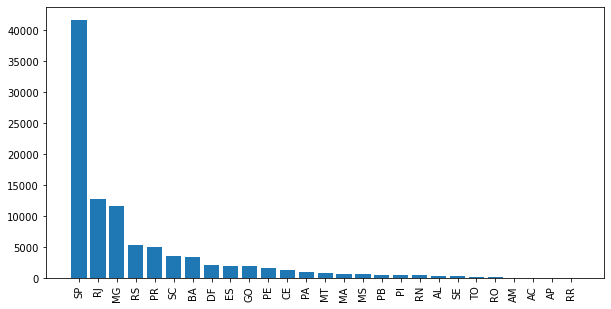

In [77]:
plt.figure(figsize = (10, 5))
plt.bar(states,customers)
plt.xticks(rotation=90)
plt.show()

# Number of orders per month in 2018

In [94]:
 query="""select month(order_purchase_timestamp) months, count(order_id) orders from orders where year(order_purchase_timestamp)=2018
group by month(order_purchase_timestamp);"""

cur.execute(query)

data= cur.fetchall()

months= [row[0] for row in data]
orders= [row[1] for row in data]

df=pd.DataFrame({'Month':months, 'Orders':orders})
df

,Month,Orders
0,1,7269
1,2,6728
2,3,7211
3,4,6939
4,5,6873
5,6,6167
6,7,6292
7,8,6512
8,9,16
9,10,4


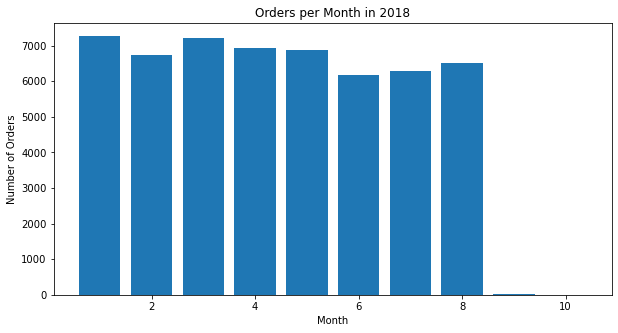

In [98]:
plt.figure(figsize=(10,5))
plt.bar(months, orders)
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.title('Orders per Month in 2018')
plt.xticks
plt.show()

# Average number of products per order by customer city

In [101]:
 query="""with product_per_order as  
(select order_items.order_id, orders.customer_id, count(order_items.order_item_id) as order_count
from order_items join orders 
on order_items.order_id= orders.order_id
group by order_items.order_id, orders.customer_id)


select customers.customer_city, AVG(product_per_order.order_count) avg_oc 
from customers join product_per_order
on customers.customer_id =product_per_order.customer_id 
group by customers.customer_city;"""

cur.execute(query)

data= cur.fetchall()

city= [row[0] for row in data]
avg = [row[1] for row in data]

df= pd.DataFrame({'City':city, 'Average orders':avg})
df

,City,Average orders
0,abadia dos dourados,1
1,abadiania,1
2,abaete,1
3,abaetetuba,1
4,abaiara,1
...,...,...
4105,xinguara,1
4106,xique-xique,1
4107,zacarias,1
4108,ze doca,1


# Total revenue percentage by product category

In [103]:
query="""with product_per_order as  
(select order_items.order_id, orders.customer_id, count(order_items.order_item_id) as order_count
from order_items join orders 
on order_items.order_id= orders.order_id
group by order_items.order_id, orders.customer_id)


select customers.customer_city, AVG(product_per_order.order_count) avg_oc 
from customers join product_per_order
on customers.customer_id =product_per_order.customer_id 
group by customers.customer_city; """

cur.execute(query)
data= cur.fetchall()

category = [row[0] for row in data]
rev_per = [row[1] for row in data]

df = pd.DataFrame({'Category': category, 'Revenue %': rev_per})
df

,Category,Revenue %
0,Fashion Bags and Accessories,1.36
1,Market Place,0.28
2,foods,0.29
3,PCs,1.74
4,telephony,3.04
...,...,...
69,flowers,0.01
70,musical instruments,1.46
71,Hygiene diapers,0.03
72,song,0.04


# Correlation between product price and number of times product purchased

In [105]:
query="""select products.product_category, count(order_items.product_id) number, round(avg(order_items.price),2) price
from products join order_items 
on products.product_id = order_items.product_id
group by products.product_category;"""

cur.execute(query)

data= cur.fetchall()

category= [row[0] for row in data]
order= [row[1] for row in data]
price= [row[2] for row in data]

df = pd.DataFrame({'Category': category, 'Orders': order, 'Price': price})
df

,Category,Orders,Price
0,Fashion Bags and Accessories,2031,75.25
1,Market Place,311,91.25
2,foods,510,57.63
3,PCs,203,1098.34
4,telephony,4545,71.21
...,...,...,...
69,flowers,33,33.64
70,musical instruments,680,281.62
71,Hygiene diapers,39,40.19
72,song,38,158.80


In [108]:
import numpy as np

arr1= order
arr2= price

np.corrcoef([arr1,arr2])

array([[ 1.        , -0.10631514],
       [-0.10631514,  1.        ]])

# Total revenue generated by each seller 

In [110]:
query="""select *, rank() over(order by revenue desc) as ranking from
(select sellers.seller_id, sum(payments.payment_value) revenue
from sellers 
join order_items on sellers.seller_id = order_items.seller_id
join payments on payments.order_id = order_items.order_id
group by sellers.seller_id) as answer;"""

cur.execute(query)
data= cur.fetchall()

seller= [row[0] for row in data]
rev= [row[1] for row in data]
rank= [row[2] for row in data]

df= pd.DataFrame({'Seller': seller, 'Revenue': rev, 'Rank': rank})
df

,Seller,Revenue,Rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.91,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.04,2
2,4a3ca9315b744ce9f8e9374361493884,301245.27,3
3,1f50f920176fa81dab994f9023523100,290253.42,4
4,53243585a1d6dc2643021fd1853d8905,284903.08,5
...,...,...,...
3090,ad14615bdd492b01b0d97922e87cb87f,19.21,3091
3091,702835e4b785b67a084280efca355756,18.56,3092
3092,4965a7002cca77301c82d3f91b82e1a9,16.36,3093
3093,77128dec4bec4878c37ab7d6169d6f26,15.22,3094


# Moving average of order values for each customer over their order history

In [116]:
query="""select *, avg(payment) over(partition by customer_id order by order_purchase_timestamp rows between 3 preceding and current row) as mov_avg from
(select orders.customer_id, orders.order_purchase_timestamp, payments.payment_value payment
from orders join payments on orders.order_id= payments.order_id) as answer;"""

cur.execute(query)
data= cur.fetchall()

customerid= [row[0] for row in data]
time= [row[1] for row in data]
avg= [row[2] for row in data]

df= pd.DataFrame({'Customer id': seller, 'Purchase timestamp': time, 'Moving avg': avg})
df

,Customer id,Purchase timestamp,Moving avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01
...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50


# Cumulative sales per month for each year

In [118]:
query= """select *, sum(sales) over(order by years, months) cum_sales from
(select year(orders.order_purchase_timestamp) as years, month(orders.order_purchase_timestamp) as months, round(sum(payments.payment_value),2) sales 
from orders join payments on orders.order_id= payments.order_id
group by year(orders.order_purchase_timestamp), month(orders.order_purchase_timestamp)) as answer;"""

cur.execute(query)

data= cur.fetchall()

years= [row[0] for row in data]
months= [row[1] for row in data]
sales= [row[2] for row in data]
cum_sales= [row[3] for row in data]

df= pd.DataFrame({'Year': years, 'Month': months, 'Sales': sales, 'Cumulative sales': cum_sales})
df

,Year,Month,Sales,Cumulative sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


# Year-over-year growth rate of total sales

In [119]:
query="""with yearly_sales as (select year(orders.order_purchase_timestamp) as years, round(sum(payments.payment_value),2) sales 
from orders join payments on orders.order_id= payments.order_id
group by year(orders.order_purchase_timestamp))

select *, (((sales-lag(sales) over(order by years))/lag(sales) over(order by years))*100) yoy_growth from yearly_sales;"""

cur.execute(query)
data= cur.fetchall()

years= [row[0] for row in data]
sales= [row[1] for row in data]
yoy= [row[2] for row in data]

df= pd.DataFrame({'Years': years, 'Sales': sales, 'YoY % growth': yoy})
df

,Years,Sales,YoY % growth
0,2016,59362.34,NaN
1,2017,7249746.73,12112.703761
2,2018,8699763.05,20.000924


# Identify the top 3 customers who spent the most money in each year

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'a9dc96b027d1252bbac0a9b72d837fc6'),
  Text(1, 0, '1d34ed25963d5aae4cf3d7f3a4cda173'),
  Text(2, 0, '4a06381959b6670756de02e07b83815f'),
  Text(3, 0, '1617b1357756262bfa56ab541c47bc16'),
  Text(4, 0, 'c6e2731c5b391845f6800c97401a43a9'),
  Text(5, 0, '3fd6777bbce08a352fddd04e4a7cc8f6'),
  Text(6, 0, 'ec5b2ba62e574342386871631fafd3fc'),
  Text(7, 0, 'f48d464a0baaea338cb25f816991ab1f'),
  Text(8, 0, 'e0a2412720e9ea4f26c1ac985f6a7358')])

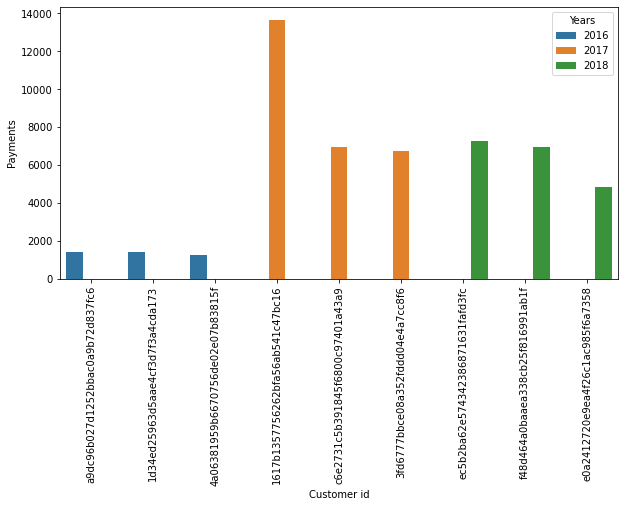

In [128]:
    query="""select * from 
    (select year(orders.order_purchase_timestamp) years, orders.customer_id, sum(payments.payment_value) payments, 
    RANK() over(partition by year(orders.order_purchase_timestamp) order by sum(payments.payment_value) desc) rank
    from orders join payments
    on orders.order_id = payments.order_id
    group by year(orders.order_purchase_timestamp), orders.customer_id) as rec 
    where rank<=3;"""

cur.execute(query)
data= cur.fetchall()

years= [row[0] for row in data]
customerid= [row[1] for row in data]
payments= [row[2] for row in data]
rank= [row[3] for row in data]

df= pd.DataFrame({'Years': years, 'Customer id': customerid, 'Payments': payments, 'Rank': rank})
df

plt.figure(figsize=(10,5))
sns.barplot(x="Customer id", y="Payments", data=df, hue= "Years")
plt.xticks(rotation=90)